Installing **cleverhans** library for performing attack

In [1]:
!pip install cleverhans

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Cloning Github repository for ResNet28 model

In [2]:
!git clone "https://github.com/Georgsiedel/Lp-norm-corruption-robustness.git"

fatal: destination path 'Lp-norm-corruption-robustness' already exists and is not an empty directory.


importing necessary libraries used in the notebook

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import torch
import torchvision
from torchvision import datasets, transforms, models
import sys
import plotly.graph_objs as go
import plotly.offline as pyo
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent

Initialize **CUDA** for GPU processing

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading **Test images** using DataLoader with **Batch size = 1**

In [5]:
BATCH_SIZE = 1

transform = transforms.Compose([transforms.ToTensor()])
testset = datasets.CIFAR10(root="~/data",
                           train=False,
                           transform=transform,
                           download=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=2)
# Testset with 500 samples only
truncated_testset, _ = torch.utils.data.random_split(testset,
                                                     [500, 9500],
                                                     generator=torch.Generator().manual_seed(42))

truncated_testloader = torch.utils.data.DataLoader(truncated_testset,
                                                   batch_size = BATCH_SIZE,
                                                   shuffle=True,
                                                   num_workers=2)

Files already downloaded and verified


Load Training model from the github repository cloned.

In [6]:
sys.path.append("/content/Lp-norm-corruption-robustness/experiments")

import network

net = network.WideResNet(28, 10, 0.3, 10)
net=  torch.nn.DataParallel(net)
PATH = "/content/wrn28-no-resize-corruption-robust.pth"
state_dict = torch.load(PATH)
net.load_state_dict(state_dict["net"], strict=True)

net.eval()

DataParallel(
  (module): WideResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (layer1): Sequential(
      (0): WideBasic(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(16, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout(p=0.3, inplace=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Sequential(
          (0): Conv2d(16, 160, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (1): WideBasic(
        (bn1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (dropout): Dropout(p=0.3, inplace=False)
        (bn2): BatchNorm2d(160, eps=1e-05, momentum=0.1, af

Projected gradient descent attack method with early stopping functionality

In [7]:
def pgd_with_early_stopping(model, inputs, labels, eps, number_of_iters, epsilon_iters, norm):

  label_flipped = False
  
  outputs = model(inputs)
  _, clean_predicted = torch.max(outputs.data, 1)
  misclassified_idx = (clean_predicted!=labels).nonzero()
  total_labels = clean_predicted if clean_predicted!=labels else labels

  for i in range(number_of_iters):

    adv_inputs = projected_gradient_descent(model,
                                            inputs,
                                            eps=eps,
                                            eps_iter=epsilon_iters,
                                            nb_iter=1,
                                            norm=norm,
                                            y = labels,
                                            rand_init=False,
                                            sanity_checks=False)
    

    outputs = model(adv_inputs)

    _, predicted = torch.max(outputs.data, 1)

    label_flipped = bool(predicted!=total_labels)
    
    if label_flipped:
      if clean_predicted!=labels:
        print(f"Iterations for successful attack on misclassified input: {i+1}")
        break
      print(f"Iterations for successful attack: {i+1}")
      break
    inputs = adv_inputs.clone()
  return adv_inputs

Clearing **CUDA** memory for efficient computation

In [8]:
torch.cuda.empty_cache()

Parameters required for attacking the test images

In [9]:
epsilon = 0.1
epsilon_iters = 0.0004
number_of_iters = 80
norm = np.inf

In [10]:
def adv_distance_calculation(testloader, model, nb):  
  distance_list_0, image_idx_0 = [], []  
  distance_list_1, image_idx_1 = [], []  
  distance_list_2, image_idx_2 = [], []

  correct_original, correct_adversarial, total = 0, 0, 0

  for i, data in enumerate(testloader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)

    adv_inputs = pgd_with_early_stopping(model, inputs, labels, epsilon, number_of_iters, epsilon_iters, norm)

    distance = torch.norm((inputs - adv_inputs), p=1)
    distance_list_0.append(distance)
    image_idx_0.append(i)

    if predicted == labels:
      distance_list_1.append(distance)
      distance_list_2.append(distance)
      image_idx_1.append(i)
      image_idx_2.append(i)
    else:
      distance_list_1.append(0)
      image_idx_1.append(i)

    adv_outputs = model(adv_inputs)
    _, adv_predicted = torch.max(adv_outputs.data, 1)

    correct_original += (predicted == labels).sum().item()
    correct_adversarial += (adv_predicted == labels).sum().item()
    total += labels.size(0)

    original_accuracy = correct_original / total
    adversarial_accuracy = correct_adversarial / total

    if i % 100 == 0:
      print(f"Images Processed: {i}, L1 Distance: {distance}, Adversarial accuracy: {adversarial_accuracy * 100}%")

  return distance_list_0, image_idx_0, distance_list_1, image_idx_1, distance_list_2, image_idx_2, original_accuracy, adversarial_accuracy

Determining Adversarial accuracies and the three types of distance calculations for different number of iterations

In [12]:
print("-----------------------------------Start Processing-----------------------------------")
print(f"Number of Iterations: {number_of_iters}")
distance_0, index0, distance_1, index1, distance_2, index2, clean_accuracy, adversarial_accuracy = adv_distance_calculation(testloader, net, number_of_iters)
print("-----------------------------------End Processing-----------------------------------")

Streaming output truncated to the last 5000 lines.
Iterations for successful attack: 11
Iterations for successful attack: 25
Iterations for successful attack: 14
Iterations for successful attack: 2
Iterations for successful attack: 20
Iterations for successful attack: 43
Iterations for successful attack: 45
Iterations for successful attack: 12
Iterations for successful attack: 10
Iterations for successful attack: 16
Iterations for successful attack: 15
Iterations for successful attack: 2
Iterations for successful attack: 15
Iterations for successful attack: 8
Iterations for successful attack: 29
Iterations for successful attack: 16
Iterations for successful attack: 5
Iterations for successful attack: 5
Iterations for successful attack: 2
Iterations for successful attack: 27
Iterations for successful attack: 35
Iterations for successful attack: 4
Iterations for successful attack: 17
Iterations for successful attack: 17
Iterations for successful attack: 28
Iterations for successful attac

In [13]:
def conv(input_metric):
  return torch.tensor(input_metric).cpu().numpy()

In [14]:
import plotly.graph_objs as go
import plotly.offline as pyo

distance_list_0_np = conv(distance_0)
distance_list_1_np = conv(distance_1)
distance_list_2_np = conv(distance_2)

with open("/content/data", "w", newline="") as csv_file:
  writer = csv.writer(csv_file)
  writer.writerows([distance_list_0_np, distance_list_1_np, distance_list_2_np])


# Create trace objects for each line plot
marker_size = 3

trace_0 = go.Scatter(x=index0, y=distance_list_0_np, mode='markers', name='L1 distances (including misclassified inputs)', marker=dict(color='red', size = marker_size))
trace_1 = go.Scatter(x=index1, y=distance_list_1_np, mode='markers', name='L1 distances (distance=0 for misclassified inputs)', marker=dict(color='green', size = marker_size))
trace_2 = go.Scatter(x=index2, y=distance_list_2_np, mode='markers', name='L1 distances (excluding for misclassified inputs)', marker=dict(color='blue', size = marker_size))

# Create a data list containing the trace objects
data = [trace_0, trace_1, trace_2]

# Define the layout for the plot
layout = go.Layout(title='L1 Distances for all Inputs and Misclassified Inputs', xaxis=dict(title='Image index'), yaxis=dict(title='L1 distance'))

# Create a figure object
fig = go.Figure(data=data, layout=layout)

# Display the plot in the notebook
pyo.iplot(fig)

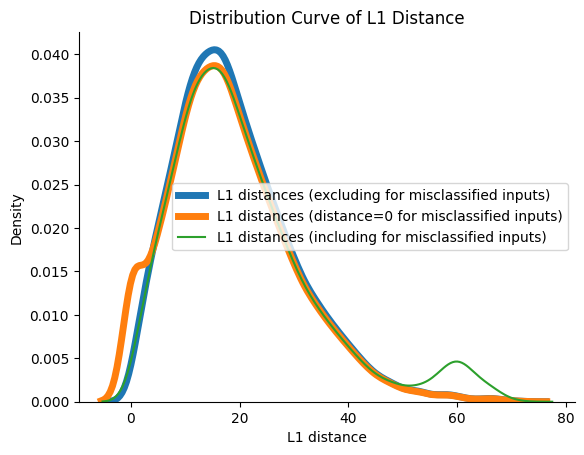

In [15]:
import seaborn as sns

linewidth = 5

sns.kdeplot(distance_list_2_np, label = 'L1 distances (excluding for misclassified inputs)', linewidth=linewidth)
sns.kdeplot(distance_list_1_np, label = "L1 distances (distance=0 for misclassified inputs)", linewidth=linewidth)
sns.kdeplot(distance_list_0_np, label = "L1 distances (including for misclassified inputs)")
sns.despine()
plt.xlabel("L1 distance")
plt.ylabel("Density")
plt.title("Distribution Curve of L1 Distance")
plt.legend()

In [16]:
print(f"Adversarial Accuracy: {adversarial_accuracy*100}%")
print(f"Clean Accuracy: {clean_accuracy*100}%")
print(f"Average Distance_0: {np.mean(distance_list_0_np)}")
print(f"Average Distance_1: {np.mean(distance_list_1_np)}")
print(f"Average Distance_2: {np.mean(distance_list_2_np)}")

Adversarial Accuracy: 0.15%
Clean Accuracy: 95.61%
Average Distance_0: 21.013071060180664
Average Distance_1: 18.45387840270996
Average Distance_2: 19.30120277404785
